In [ ]:
import seaborn as sns 
from matplotlib import pyplot as plt 
import pandas as pd
import numpy as np
import os
import re 
import nltk 
from nltk.stem import WordNetLemmatizer
import spacy 
from collections import Counter

In [ ]:
YEARS = np.arange(2015, 2021)
PARTS = {2015: 21, 2016: 14, 2017: 27, 2018: 28, 2019: 22, 2020: 6}  # define dataset parameters

In [ ]:
full_wiki = pd.read_json("result_data.json")

In [ ]:
full_wiki.head()

,date_of_birth,nationality,gender,occupation,Speaker,Quote,numOccurrences,quote_year,quote_month
0,1952,[United Kingdom],[male],"[playwright, screenwriter, novelist, children'...",douglas adams,To claim that homosexual behavior is wrong wou...,1,2015,5
1,1952,[United Kingdom],[male],"[playwright, screenwriter, novelist, children'...",douglas adams,"You can't get away with saying, `If you try to...",1,2017,11
2,1946,[United States of America],[male],"[politician, motivational speaker, autobiograp...",george w. bush,"There should be protections, and so, as it rel...",2,2015,3
3,1946,[United States of America],[male],"[politician, motivational speaker, autobiograp...",george w. bush,But there is one area where I have done much t...,1,2015,6
4,1946,[United States of America],[male],"[politician, motivational speaker, autobiograp...",george w. bush,Bush is set to accept the award at an event wh...,1,2016,5


## 2) Preprocess data for natural language processing 
To calculate initial statistics, plot distributions and make preliminary analysis from the words frequency point of view we decided to preprocess data: 
Example: "I like dogs!" 
1. Removed punctuation: "I like dogs" 
2. Normalized the case: "i like dogs" 
3. Tokenize them: ["i", "like", "dogs"]
4. Lemmatize them: ["i", "like", "dog"] 
5. Remove stopwords that don't give a lot of information: ["like", "dog"] 

In [ ]:
full_str = "".join(full_wiki.Quote)  # from quotes dataframe to string 
full_str[:100]

"To claim that homosexual behavior is wrong would be to hold others to a moral standard to which one'"

In [ ]:
full_str = re.sub(r'[^\w]', " " , full_str)  # remove punctuation 
full_str[:100]

'To claim that homosexual behavior is wrong would be to hold others to a moral standard to which one '

In [ ]:
full_str = full_str.lower()  # normalize case 
full_str[:100]

'to claim that homosexual behavior is wrong would be to hold others to a moral standard to which one '

In [ ]:
nltk.download('punkt')
tokens = nltk.tokenize.word_tokenize(full_str)  # tokenize 
tokens[:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['to',
 'claim',
 'that',
 'homosexual',
 'behavior',
 'is',
 'wrong',
 'would',
 'be',
 'to']

In [ ]:
words_amount = 100  # how many the most frequent words we wan to check
count = Counter(tokens)  
words = dict(count.most_common(words_amount))

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])  # lemmatize 
doc = nlp(" ".join([list(words.keys())[k] for k in range(words_amount)]))
lemmas = [token.lemma_ for token in doc]
lemmas[:10]

['the', 'and', 'to', 'of', 'a', 'i', 'that', 'in', '-PRON-', 'be']

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')  # removing stopwords and damaged by symbols words
clean_words = dict([(i, idx) for idx, i in enumerate(lemmas) if ((i not in stopwords) and (len(i) >= 3))])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's summarize all preprocessing for text data in a function. 

In [ ]:
def preprocess_text(year, words_amount=100):
  """
  Returns $words amount$ the most frequent words of quotes for $year$
  params: year - the year of mentionning the quote
  params: words_amount - how many the most frequent words we want to check
  """
  text = "".join(full_wiki.Quote.iloc[np.where(full_wiki.quote_year == year)]) 
  full_str = re.sub(r'[^\w]', " " , text).lower()
  tokens = nltk.tokenize.word_tokenize(full_str)  # tokenize
  count = Counter(tokens)  # count words
  words = dict(count.most_common(words_amount))
  nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])  # lemmatize 
  doc = nlp(" ".join([list(words.keys())[k] for k in range(words_amount)]))
  lemmas = [token.lemma_ for token in doc]
  stopwords = nltk.corpus.stopwords.words('english')  # removing stopwords and damaged by symbols words
  clean_words = dict([(i, idx) for idx, i in enumerate(lemmas) if ((i not in stopwords) and (len(i) >= 3))])
  return {elem: list(words.values())[clean_words[elem]] for elem in set(clean_words)}

## 3) Initial analysis 

Firstly, we decided to check if research questions are feasible. If the interest in gender-related topics hasn't noticeably changed for these years, it will be complicated to find enhancements. We looked at the frequency of gender-related topics mentioned in quotes depending on the year.   

In [ ]:
# creates path string to parsed file 
get_file_name = lambda year, part: os.path.join(PROJECT_PATH, f"Data/Parsed data/IdQuotes{year}_{part}.json")

In [279]:
key_words_lgbt = "marriage equality|gay|same-sex|same-sex marriage|\
    gay marriage|homosexual marriage|same-gender marriage|lesbian|lesbians|gays|\
    lesbian|bisexual|transgender|transsexual|queer|questioning sexual identity|\
    questioning gender identity|intersex|asexual|pansexual|LGBT|LGBTQ|LGBTQI|LGBTQIA|\
    LGBTQIAA|LGBTQI2A|LGBTQIAAP|LGBTQI2AP|LGBTTQIAAP|LGBTTQI2AP|LGBT+|LGBTQ+|LGBTQI+|\
    LGBTQIA+|LGBTQIAA+|LGBTQI2A+|LGBTQIAAP+|LGBTQI2AP+|LGBTTQIAAP+|LGBTTQI2AP+| polysexual|\
    demisexual|gayprideasexual|asexuals|asexuality|bisexual|bisexuals|bisexuality|cisgender|\
    cisgenders|cisgenderism|demisexual|demisexuals|demisexuality|gay|gays|gaypride|gender \
    fluidity|heteronormative|heteronormatives|heteronormativity|hetero sexual|hetero sexuals|\
    heterosexual|heterosexuals|heterosexuality|homo sexual|homo sexuals|homosexual|homo sexuals|\
    homosexuality|inter sex|intersex|intersexual|intersexuals|intersexuality|lesbian|lesbians|\
    lgbt|lgbt+|lgbtq|lgbtq+|lgbtqi|lgbtqi+|lgbtqi2a|lgbtqi2a+|lgbtqi2ap|lgbtqi2ap+|lgbtqia|\
    lgbtqia+|lgbtqiaa|lgbtqiaa+|lgbtqiaap|lgbtqiaap+|lgbttqi2ap|lgbttqi2ap+|lgbttqiaap|\
    lgbttqiaap+|pan sexual|pan sexuals|pansexual|pansexuals|pansexuality|poly sexual|poly\
    sexuals|polysexual|polysexuals|polysexuality|queer|queers|questioning gender identity|\
    questioning sexual identity|trans gender|trans genders|transgender|transgenders|\
    transgenderism|trans misoginy|transmisoginy|trans phobia|transphobia|transphobic|\
    trans sexual|trans sexuals|transsexual|transsexuals|transsexuality"
key_words_fem = "gender roles|misandry|misogyny|patriarchy|sexism|woman empowerement|toxic masculinity|\
    women's rights|sex equality|women's role|role of women|women's liberation|feminism|feminists"

In [280]:
contains_key_words = full_wiki["Quote"].str.contains(key_words_fem) # find index containing keywords
data_fem = full_wiki.iloc[np.where(contains_key_words)].reset_index()
contains_key_words = full_wiki["Quote"].str.contains(key_words_lgbt) # find index containing keywords
data_lgbt = full_wiki.iloc[np.where(contains_key_words)].reset_index()

### Percentage of all data

In [ ]:
# get quantities of quotes from all data and from target data 
shape_all, shape_target_data = [], [] 
for year in YEARS:
  cur_all = pd.read_json(get_file_name(year, PARTS[year]-1))
  cur_target = pd.read_json(os.path.join(PROJECT_PATH, f"Data/key_words{year}.json"))
  shape_all.append(cur_all.shape[0])
  shape_target_data.append(cur_target.shape[0])

In [ ]:
shape_all = [elem + 1e6 * PARTS[idx + 2015] for idx, elem in enumerate(shape_all)]
data = [shape_target_data[idx] / elem for idx, elem in enumerate(shape_all)]

In [ ]:
sns.set_theme()

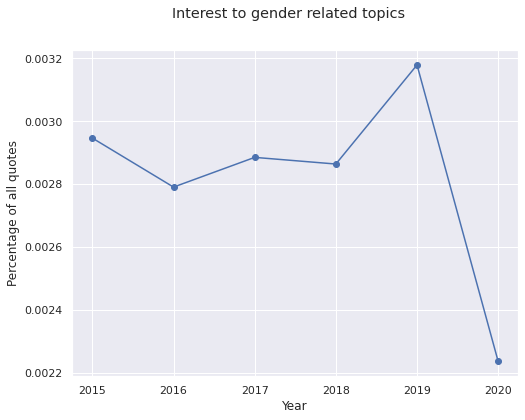

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(YEARS, data, "-o")
plt.xlabel("Year")
plt.ylabel("Percentage of all quotes")
plt.suptitle("Interest to gender related topics");

### Quotes distribution 

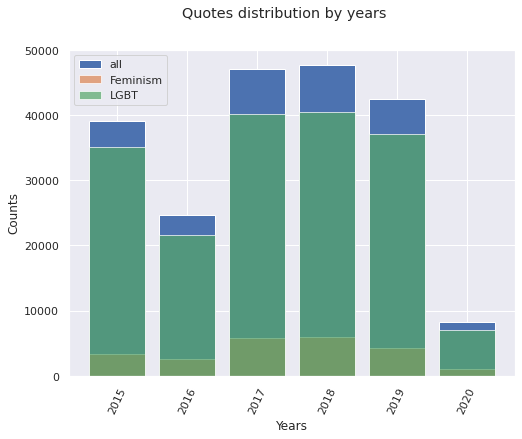

In [285]:
year_quotes = {year: (full_wiki.quote_year == year).sum() for year in YEARS} 
year_quotes_fem = {year: (data_fem.quote_year == year).sum() for year in YEARS} 
year_quotes_lgbt = {year: (data_lgbt.quote_year == year).sum() for year in YEARS} 
plt.figure(figsize=(8, 6))
plt.suptitle("Quotes distribution by years")
plt.xlabel("Years")
plt.ylabel("Counts")
plt.xticks(rotation=65)
plt.bar(year_quotes.keys(), year_quotes.values(), label="all")
plt.bar(year_quotes_fem.keys(), year_quotes_fem.values(), alpha=0.7, label="Feminism")
plt.bar(year_quotes_lgbt.keys(), year_quotes_lgbt.values(), alpha=0.7, label="LGBT")
plt.legend(loc="best")

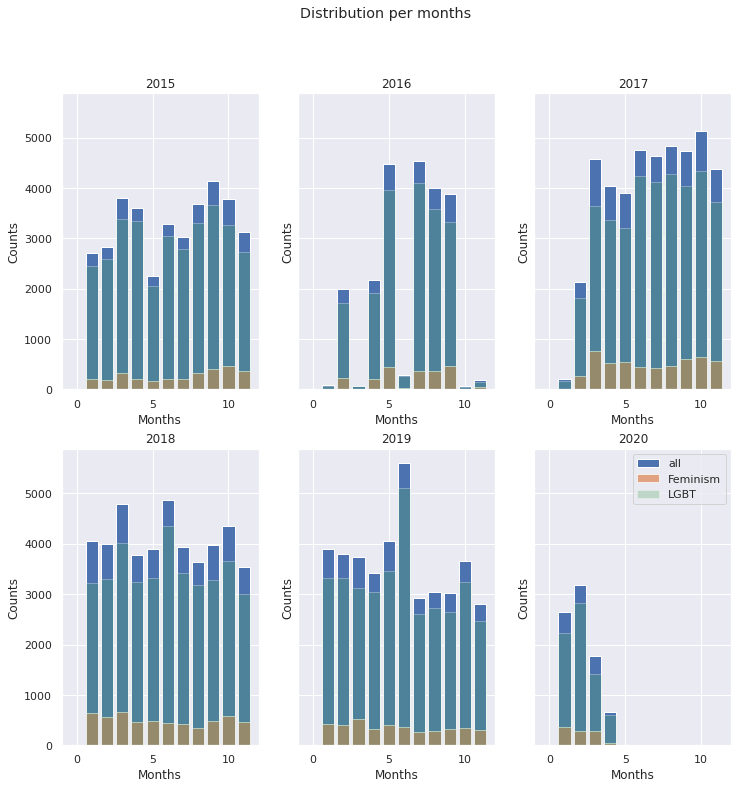

In [287]:
fig, axs = plt.subplots(2, 3, figsize=(12, 12), sharey=True)
fig.suptitle(f"Distribution per months")

for idx, year in enumerate(YEARS):
  data = {month: ((full_wiki.quote_year == year) & (full_wiki.quote_month == month)).sum() for month in range(12)} 
  data_f = {month: ((data_fem.quote_year == year) & (data_fem.quote_month == month)).sum() for month in range(12)} 
  data_l = {month: ((data_lgbt.quote_year == year) & (data_lgbt.quote_month == month)).sum() for month in range(12)} 
  axs[idx // 3, idx % 3].set_xlabel("Months")
  axs[idx // 3, idx % 3].set_ylabel("Counts")
  axs[idx // 3, idx % 3].set_title(year)
  axs[idx // 3, idx % 3].bar(data.keys(), data.values(), label="all")
  axs[idx // 3, idx % 3].bar(data_f.keys(), data_f.values(), alpha=0.7, label="Feminism")
  axs[idx // 3, idx % 3].bar(data_l.keys(), data_l.values(), alpha=0.3, label="LGBT")
plt.legend(loc="best")

### Words frequency 

After that, we checked which words were the most frequent quotes containing keywords.

In [ ]:
common_words = {elem: list(words.values())[clean_words[elem]] for elem in set(clean_words)}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


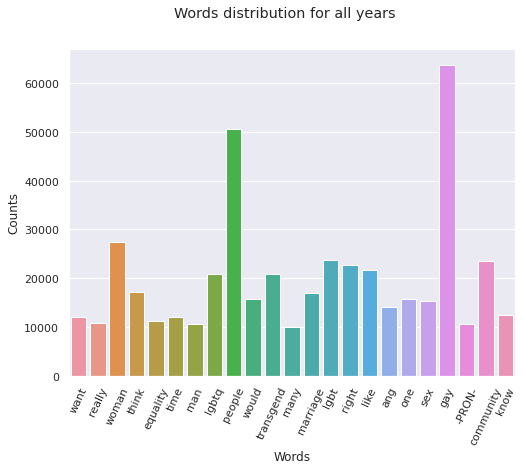

In [289]:
plt.figure(figsize=(8, 6))
plt.suptitle("Words distribution for all years")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.xticks(rotation=65)
sns.barplot(list(common_words.keys()), list(common_words.values()));

We plotted the distribution of the most frequent words by year.  

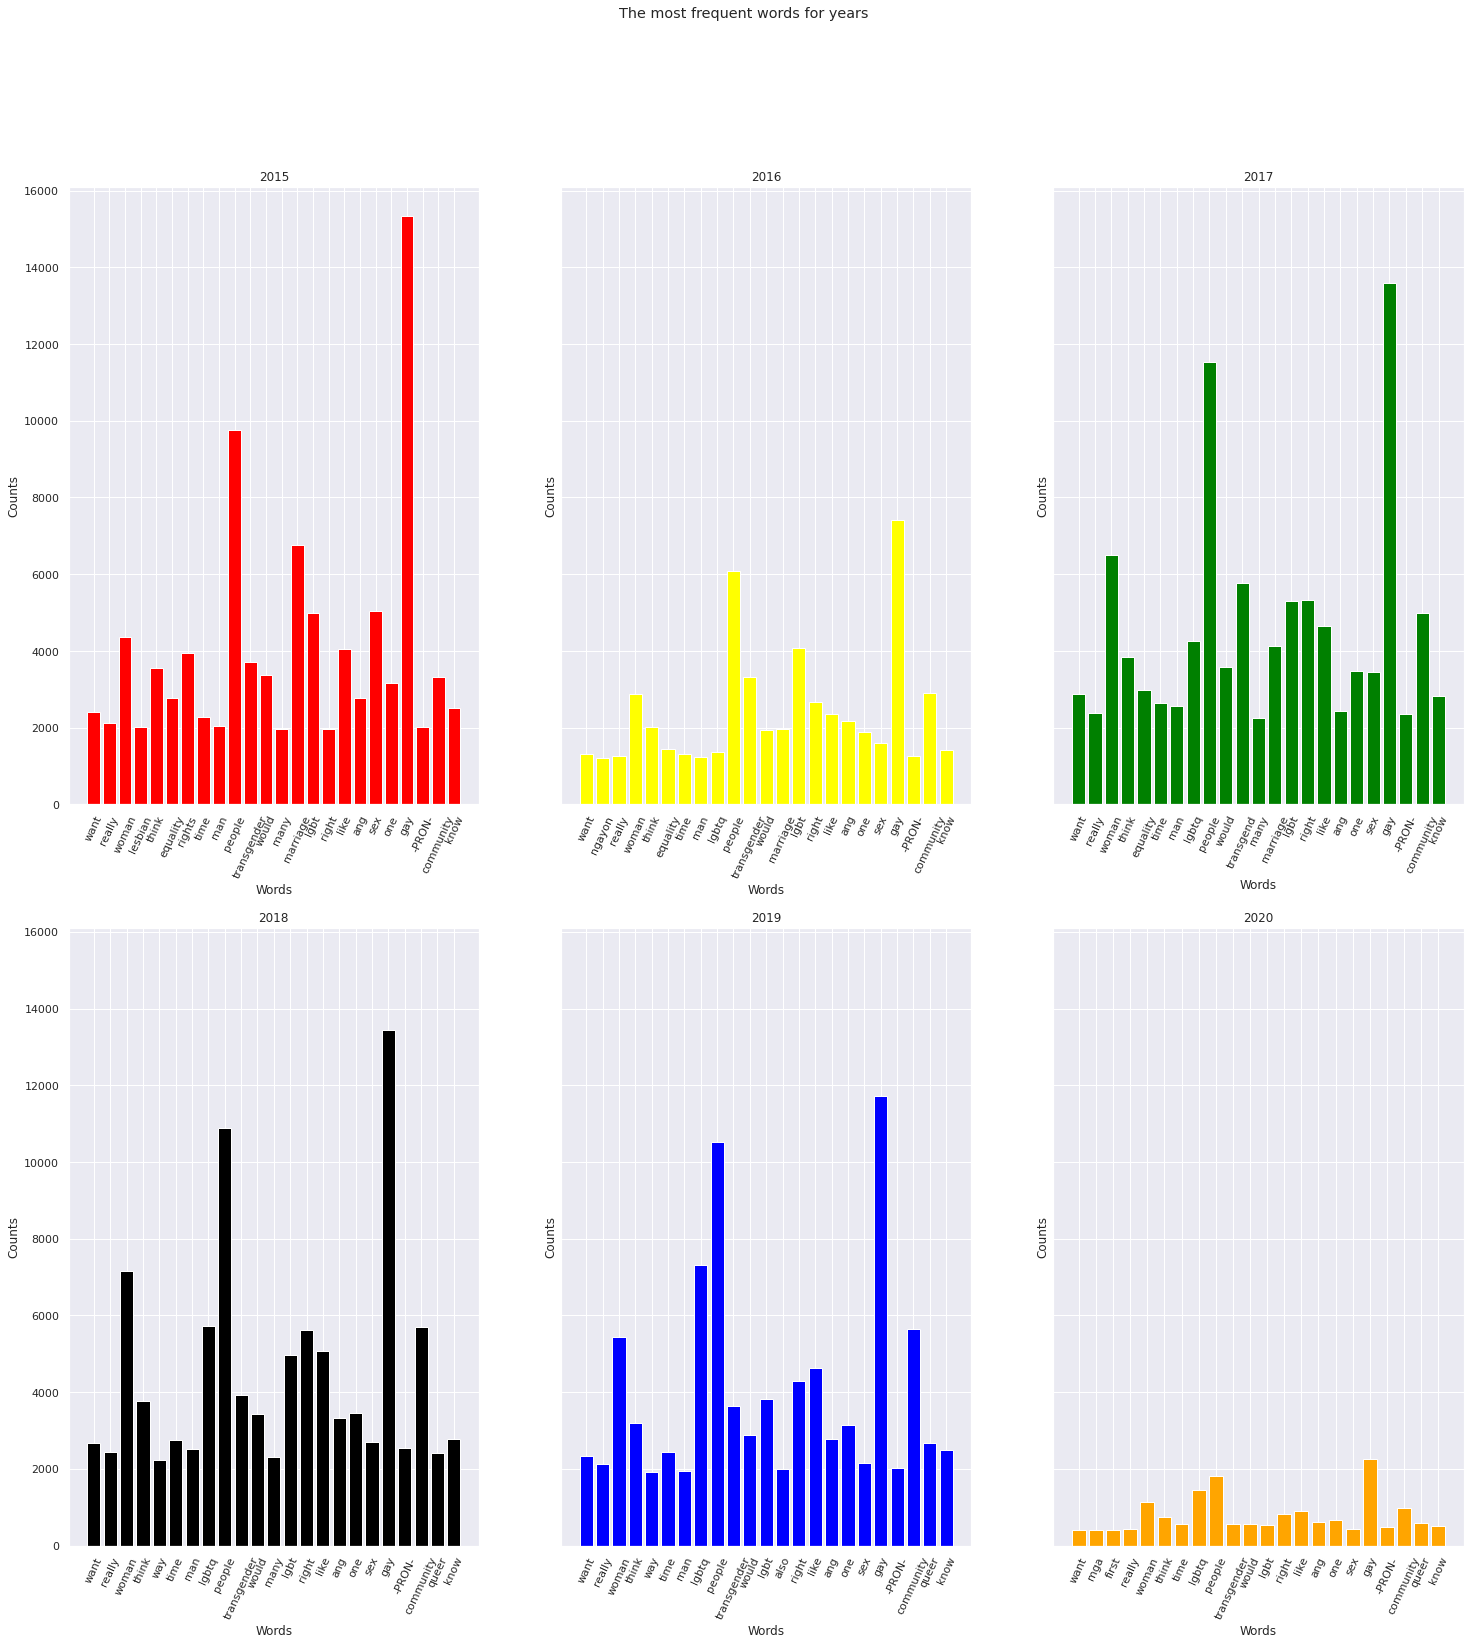

In [291]:
fig, axs = plt.subplots(2, 3, figsize=(25, 25), sharey=True)
fig.suptitle(f"The most frequent words for years")
all_colors = ['red', 'yellow', 'green', 'black', 'blue', 'orange']

for idx, year in enumerate(YEARS):
  data = preprocess_text(year)
  axs[idx // 3, idx % 3].set_xlabel("Words")
  axs[idx // 3, idx % 3].set_ylabel("Counts")
  axs[idx // 3, idx % 3].set_title(year)
  axs[idx // 3, idx % 3].set_xticklabels(data.keys(), rotation=65)
  axs[idx // 3, idx % 3].bar(data.keys(), data.values(), color=all_colors[year - 2015])

###Word cloud 

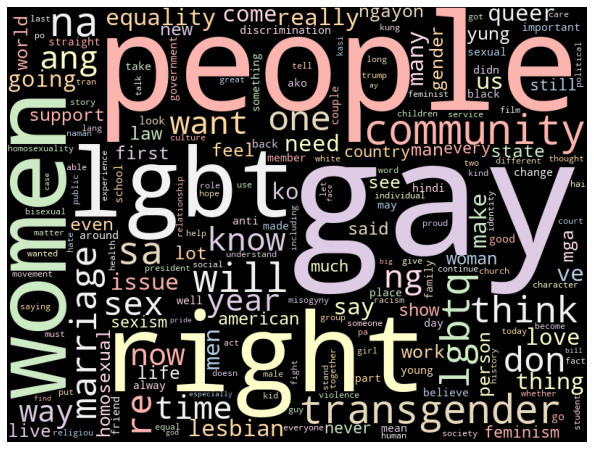

In [ ]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(width=800, height=600, random_state=1, background_color='black', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(full_str)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.axis("off");

### Genders distribution

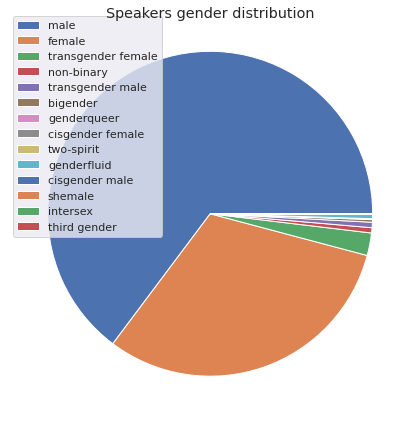

In [ ]:
genders = dict(Counter([elem[0] if len(elem) == 1 else "bigender" for elem in full_wiki.gender.dropna()]))
plt.figure(figsize=(8, 6))
plt.suptitle("Speakers gender distribution")
patches, texts = plt.pie(genders.values())
plt.legend(patches, genders.keys(), loc="best")
plt.tight_layout();

### Nationalities distribution 

In [ ]:
nationalities = np.hstack(full_wiki.nationality.dropna().to_numpy())
nationalities[:5]

array(['United Kingdom', 'United Kingdom', 'United States of America',
       'United States of America', 'United States of America'],
      dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


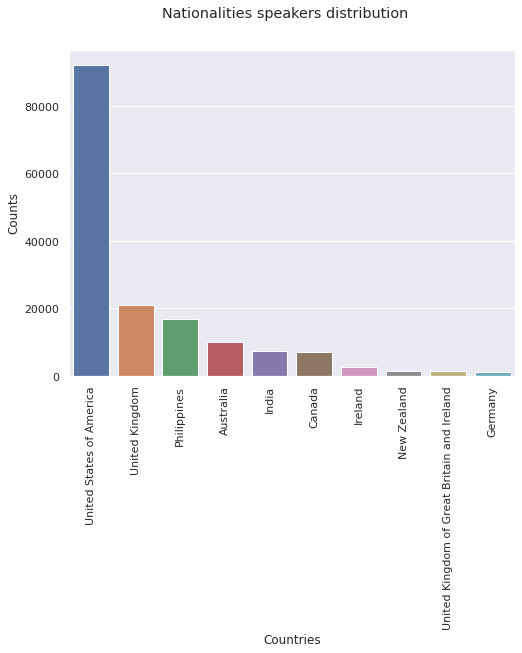

In [288]:
most_common = dict(Counter(nationalities).most_common(10))
plt.figure(figsize=(8, 6))
plt.suptitle("Nationalities speakers distribution")
plt.xlabel("Countries")
plt.ylabel("Counts")
plt.xticks(rotation=90)
sns.barplot(list(most_common.keys()), list(most_common.values()));

In [ ]:
data_nats = dict(Counter(nationalities))
del data_nats[None]

In [ ]:
data_nats_dict = {"CountryName": list(data_nats.keys()), "Counts": list(data_nats.values())}

In [ ]:
df = pd.DataFrame.from_dict(data_nats_dict)

In [ ]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
def get_continent(col):
    """
    Converts to alpah2 country codes and continents
    params: col - country name 
    """
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return (cn_a2_code, cn_continent)

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
def geolocate(country):
    """
    Returns longitude and latitude data from country name
    params: country - name of country 
    """
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [ ]:
df["codes"] = [geolocate(elem) for elem in df.CountryName]  # get coords
df.head()  # check data

,CountryName,Counts,codes,Latitude,Longitude
0,United Kingdom,21086,"(54.7023545, -3.2765753)",54.702354,-3.276575
1,United States of America,92088,"(39.7837304, -100.445882)",39.783730,-100.445882
2,Canada,7031,"(61.0666922, -107.991707)",61.066692,-107.991707
3,India,7335,"(22.3511148, 78.6677428)",22.351115,78.667743
4,France,996,"(46.603354, 1.8883335)",46.603354,1.888334


In [ ]:
df['Latitude'], df['Longitude'] = df.codes.str

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [ ]:
# Create a world map to show distributions of users 
import folium
from folium.plugins import MarkerCluster
#empty map
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(df.dropna())):
        lat = df.iloc[i]['Latitude']
        long = df.iloc[i]['Longitude']
        if not np.isnan(lat) and not np.isnan(long):
          radius = 5
          popup_text = """Country : {}<br>
                      %of Speakers : {}<br>"""
          popup_text = popup_text.format(df.iloc[i]['CountryName'],
                                    df.iloc[i]['Counts']
                                    )
          folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill=True).add_to(marker_cluster)
#show the map
world_map

### Occupation

In [292]:
occupations = full_wiki.occupation.dropna().apply(lambda x: x[0]).to_numpy()
occupations[:5]

array(['playwright', 'playwright', 'politician', 'politician',
       'politician'], dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


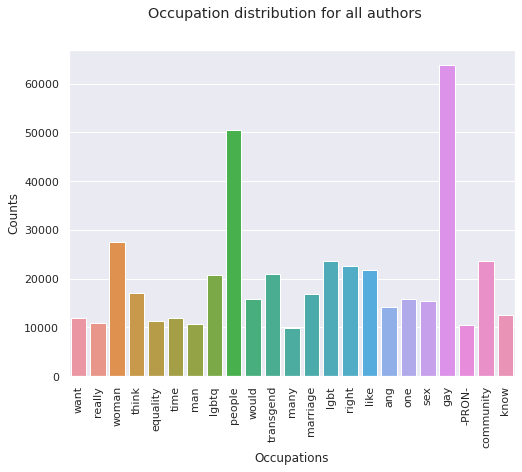

In [293]:
most_common = dict(Counter(occupations).most_common(10))

plt.figure(figsize=(8, 6))
plt.suptitle("Occupation distribution for all authors")
plt.xlabel("Occupations")
plt.ylabel("Counts")
plt.xticks(rotation=90)
sns.barplot(list(common_words.keys()), list(common_words.values()));